In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import syft as sy
hook=sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/root/anaconda3/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0.so'


### Creating two clients and fitting a linear regression made with a neural network

In [2]:
#torch.rand => uniform distribution

dim=100

X1=torch.rand(dim, 1) 
X2=torch.rand(dim,1)

a_1,b_1=5,-1
a_2,b_2=4,-1.2
y1=a_1*X1+b_1+0.5*torch.randn(dim,1)
y2=a_2*X2+b_2+0.5*torch.randn(dim,1)

### FedAvg for the two clients created above

In [3]:
#Create the server and the clients
server = sy.VirtualWorker(hook, id="server")
C1 = sy.VirtualWorker(hook, id="C1")
C2 = sy.VirtualWorker(hook, id="C2")

#Send the features and the labels to its associated client
C1_x = X1.send(C1)
C1_y = y1.send(C1)

C2_x = X2.send(C2)
C2_y = y2.send(C2)

In [4]:
#metrics we are interested in
C1_loss_hist=[]
C2_loss_hist=[]
S_loss_hist=[]
C1_a_grad=[]
C1_b_grad=[]
C2_a_grad=[]
C2_b_grad=[]

#torch model used for the inference
model = nn.Linear(1,1)

loss_f=nn.MSELoss()
iterations=100
epochs=2
precision=100
epsilon =10**-10
iter_max=1000
i=0

#print(model.weight.data.numpy(),model.bias.data.numpy())

while precision>epsilon and i<iter_max:
    C1_model = model.copy().send(C1)
    C2_model = model.copy().send(C2)
    
    C1_opt = optim.SGD(params=C1_model.parameters(),lr=0.1)
    C2_opt = optim.SGD(params=C2_model.parameters(),lr=0.1)
    
    for j in range(epochs):
        
        # Train Bob's Model
        C1_opt.zero_grad()
        C1_pred = C1_model(C1_x)
        C1_loss = loss_f(C1_pred,C1_y)
        C1_loss.backward()

        C1_opt.step()
        C1_loss = C1_loss.get().data
                
        # Train Alice's Model
        C2_opt.zero_grad()
        C2_pred = C2_model(C2_x)
        C2_loss = loss_f(C2_pred,C2_y)
        C2_loss.backward()

        C2_opt.step()
        C2_loss = C2_loss.get().data
    
    C1_loss_hist+=[C1_loss.numpy()]
    C2_loss_hist+=[C2_loss.numpy()]
    S_loss_hist+=[(C1_loss.numpy()+C2_loss.numpy())/2]
    
    try:precision=(S_loss_hist[-1]-S_loss_hist[-2])**2
    except:pass
    
    C1_model.move(server)
    C2_model.move(server)

    with torch.no_grad():
        
        C1_weight=C1_model.weight.clone().get()
        C2_weight=C2_model.weight.clone().get()
        
        C1_bias=C1_model.bias.clone().get()
        C2_bias=C2_model.bias.clone().get()  
        
        C1_a_grad+=[np.reshape(C1_weight.grad.numpy(),1)]
        C1_b_grad+=[C1_bias.grad.numpy()]
        
        C2_a_grad+=[np.reshape(C2_weight.grad.numpy(),1)]
        C2_b_grad+=[C2_bias.grad.numpy()]        
        
        new_weight=((C1_weight.data + C2_weight.data) / 2)
        new_bias=((C1_bias.data + C2_bias.data) / 2)
        
        model.weight.set_(new_weight)
        model.bias.set_(new_bias)
    
    if i%10==0:
        print("iteration "+str(i))
        print(model.weight.data.numpy(),model.bias.data.numpy())
        print("C1:" + str(C1_loss.detach().numpy()) + " C2:" + str(C2_loss.detach().numpy()))
        print(precision)
    
    i+=1

iteration 0
[[0.83055323]] [0.48345625]
C1:2.0516183 C2:1.3990645
100
iteration 10
[[1.8755908]] [0.24184352]
C1:1.0969262 C2:0.8924713
0.001788492171513667
iteration 20
[[2.5642393]] [-0.12472927]
C1:0.74767035 C2:0.6139956
0.0005766004447913531
iteration 30
[[3.082661]] [-0.40138364]
C1:0.54342043 C2:0.46173194
0.00018604598011862095
iteration 40
[[3.4731507]] [-0.6097695]
C1:0.42271835 C2:0.37988502
6.007596711299357e-05
iteration 50
[[3.7672784]] [-0.7667316]
C1:0.35060644 C2:0.33686963
1.9419972673517805e-05
iteration 60
[[3.9888241]] [-0.88496006]
C1:0.30695826 C2:0.3150412
6.285503118874658e-06
iteration 70
[[4.155699]] [-0.974013]
C1:0.28013405 C2:0.30459762
2.038356004874231e-06
iteration 80
[[4.281393]] [-1.0410901]
C1:0.26336357 C2:0.30013412
6.625325568165863e-07
iteration 90
[[4.3760695]] [-1.0916146]
C1:0.25267988 C2:0.29870287
2.1595316557210253e-07
iteration 100
[[4.447382]] [-1.1296707]
C1:0.24573794 C2:0.2987202
7.078011865502276e-08
iteration 110
[[4.5010977]] [-1.15

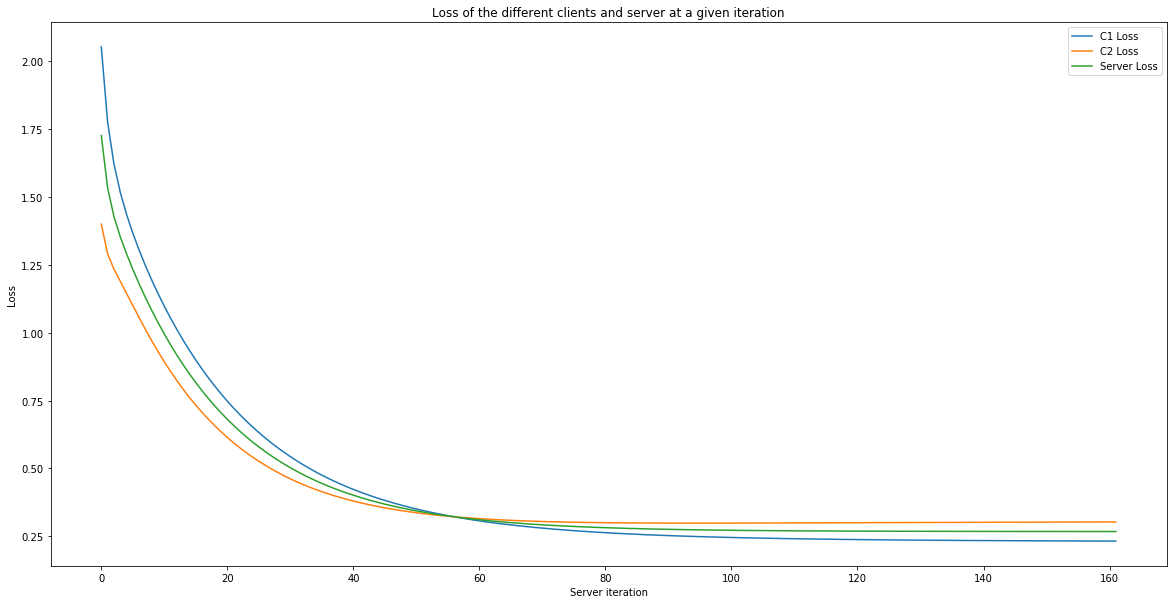

In [6]:
plt.figure(figsize=(20,10))
plt.plot(C1_loss_hist,label="C1 Loss")
plt.plot(C2_loss_hist,label="C2 Loss")
plt.plot(S_loss_hist,label="Server Loss")
plt.title("Loss of the different clients and server at a given iteration")
plt.xlabel("Server iteration")
plt.ylabel("Loss")
plt.legend()

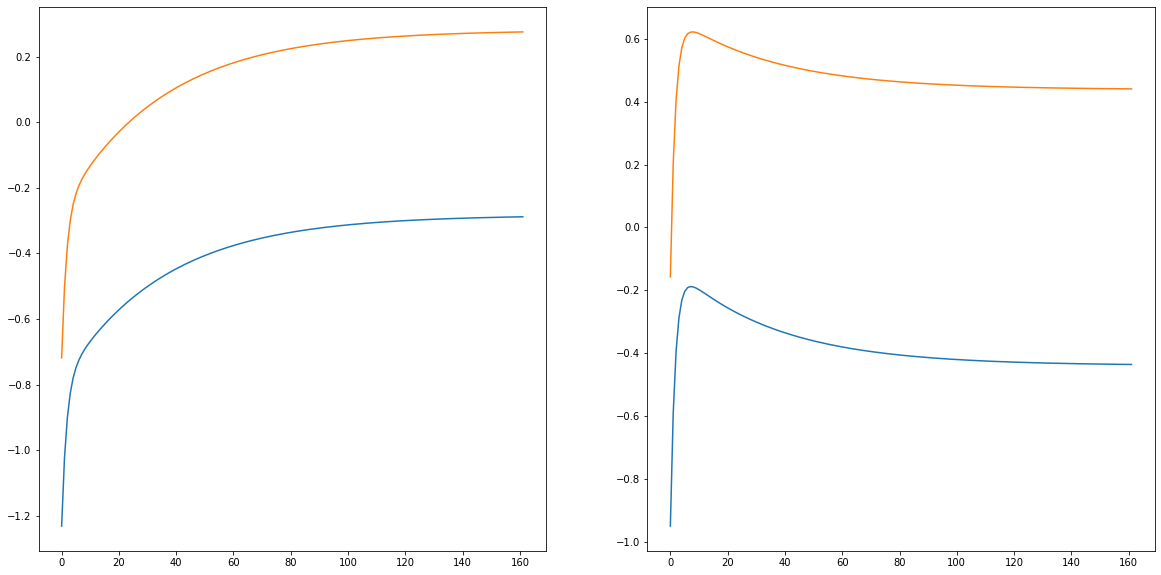

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(C1_a_grad)
plt.plot(C2_a_grad)

plt.subplot(1,2,2)
plt.plot(C1_b_grad)
plt.plot(C2_b_grad)


#plt.legend()

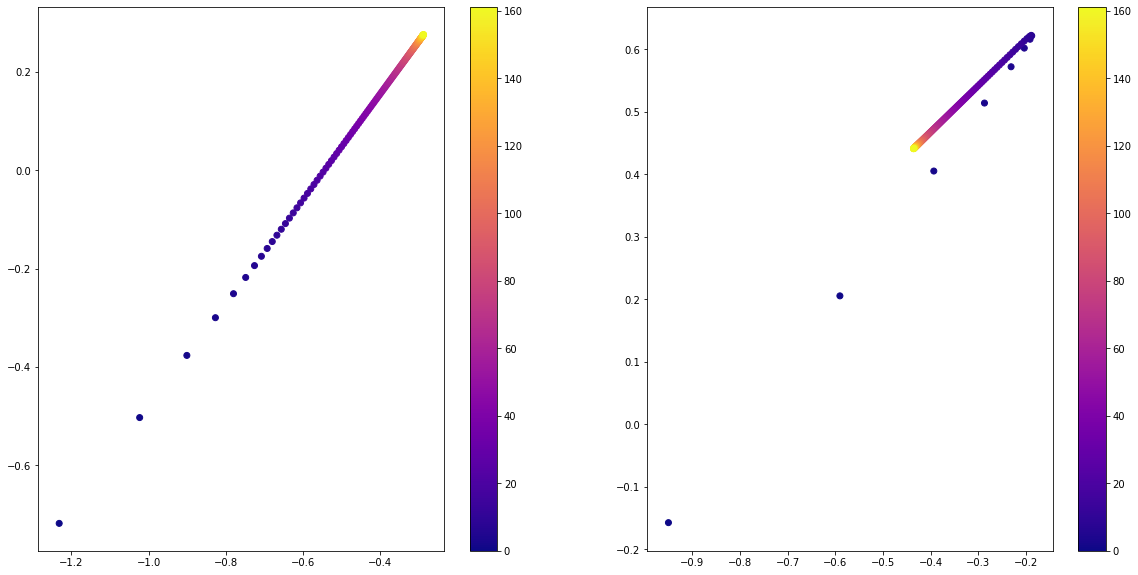

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)

plt.scatter(C1_a_grad,C2_a_grad,c=[[i] for i in range(len(C1_a_grad))],cmap='plasma')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(C1_b_grad,C2_b_grad,c=[[i] for i in range(len(C1_a_grad))],cmap='plasma')
plt.colorbar()